# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples

In [1]:
TGT='Reply'
PRFX='Reply0405_4'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(1e5)#int(1e5)
trnsz = int(1e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.set_verbosity(optuna.logging.ERROR)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(100000, 24)


retwt          0.11211
reply          0.02754
like           0.43929
retwt_cmmnt    0.00801
dtype: float64

CPU times: user 758 ms, sys: 60.1 ms, total: 818 ms
Wall time: 817 ms


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(370000, 24)


retwt          0.112570
reply          0.028143
like           0.438841
retwt_cmmnt    0.007565
dtype: float64

CPU times: user 2.81 s, sys: 260 ms, total: 3.07 s
Wall time: 3.06 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(100000, 24) 0.10413
370000 10413 100000 10413


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
5,101\t1434\t107854\t18260\t31904\t111431\t74759...,NaN,0EB15633A8CC0A6E3917C272F43E6DF3,NaN,NaN,NaN,TopLevel,022EC308651FACB02794A8147AEE1B78,1581218899,A7E00C86B4E3709D589754A51042A360,1198215,662,True,1246548812,016212C070A76EAB37E8ED93CA509BA9,0,42,False,1578271262,False,False,True,False,False
51,101\t10473\t10116\t10132\t12603\t97953\t25307\...,NaN,7C71C144E7B9F2D87F1F4DDB40AB1C49,NaN,NaN,NaN,TopLevel,2996EB2FE8162C076D070A4C8D6532CD,1581203618,B0CBECD53C3B945C875C55DDFF56D13F,1424,854,False,1394906655,01625341E5A48963E5AA7DFFDC4436D4,643,327,False,1372760933,True,False,True,False,False
63,101\t56898\t137\t24362\t131\t100\t196\t36351\t...,NaN,ADCF033A7C7087C1506E2BC3E2D8F092,NaN,NaN,NaN,Retweet,717293301FE296B0B61950D041485825,1581258397,ECD90FC37F0A7C15C82834FDDEEDC21A,1753,811,False,1568347799,01625CCEC5A4C322FC247DB9E223CC08,147,1355,False,1355850070,False,False,True,False,False
75,101\t12441\t105702\t793\t61783\t34022\t60578\t...,NaN,7EB0824DDA3D28844CC0FF65B7C4AA08,NaN,NaN,NaN,TopLevel,167115458A0DBDFF7E9C0C53A83BAC9B,1581271814,D905F31F909CC63C2BBEB7F6B43487FE,175998,116,False,1466830888,01626B64A2570C2807AB97716262FBA9,90,139,False,1364278366,False,False,True,False,False
83,101\t69532\t10107\t12372\t10160\t19048\t136\t1...,NaN,0A95516F028EBFF6B551DB32C4B2D1B5,Video,NaN,NaN,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581214010,88E80BAB56E6F59E4EF012A8B12D3BAE,8825,8024,False,1557262802,0162759D8908AA8C849F06086A023D85,26265,24215,False,1557422269,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    
    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-06 13:06:14 start
2020-04-06 13:06:16 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 13:06:18 freq of tags
2020-04-06 13:06:19 done
CPU times: user 4.54 s, sys: 216 ms, total: 4.76 s
Wall time: 4.71 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-06 13:06:19 start
2020-04-06 13:06:21 freq of columns using CountEncoder
2020-04-06 13:06:22 freq of tags
2020-04-06 13:06:23 done
CPU times: user 4 s, sys: 65.4 ms, total: 4.06 s
Wall time: 4.04 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'len_toks',
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 'has_hshtgs',
       'n_hshtgs', 'has_media', 'n_media', 'has_domns', 'n_domns', 'dayofweek',
       'hour', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twt_age',
       'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age', 'u1_fllwng_cnt_by_age',
       'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp', 'frq_lang', 'frq_u1id',
       'frq_u1_fllwing_cnt', 'frq_u1_vrfed', 'frq_u2id', 'frq_u2_fllwer_cnt',
       'frq_u2_vrfed', 'frq_u1_fllw_u2', 'frq_n_media_Photo',
       'frq_n_media_Video', 'frq_n_media_GIF', 'frq_has_hshtgs',
       'frq_n_hshtgs', 'frq_has_media', 'frq_n_media', 'frq_has_domns',
       'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2', 'frq_langhour',
       'sumfrq_hshtgs', 'maxfrq_hshtgs', 'su

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 4.79 s, sys: 0 ns, total: 4.79 s
Wall time: 4.77 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

In [16]:
dftr.dtypes

twttyp                   category
lang                     category
u1_fllwer_cnt               int64
u1_fllwing_cnt              int64
u1_vrfed                     bool
u2_fllwer_cnt               int64
u2_fllwng_cnt               int64
u2_vrfed                     bool
u1_fllw_u2                   bool
retwt                        bool
reply                        bool
like                         bool
retwt_cmmnt                  bool
len_toks                    int64
n_media_Photo               int64
n_media_Video               int64
n_media_GIF                 int64
has_hshtgs                   bool
n_hshtgs                    int64
has_media                    bool
n_media                     int64
has_domns                    bool
n_domns                     int64
dayofweek                   int64
hour                        int64
tmdlta_u2u1                 int64
tmdlta_twtu1                int64
tmdlta_twtu2                int64
twt_age                     int64
u1_age        

# model

In [17]:
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]

In [18]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [19]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,
    
}
results['params'] = params

In [20]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25547	vl's binary_logloss: 0.29522
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.265471	vl's binary_logloss: 0.294583


tune_feature_fraction, val_score: 0.294583:  14%|#4        | 1/7 [00:01<00:08,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25339	vl's binary_logloss: 0.296409
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.264539	vl's binary_logloss: 0.29559


tune_feature_fraction, val_score: 0.294583:  29%|##8       | 2/7 [00:02<00:06,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251145	vl's binary_logloss: 0.296517
Early stopping, best iteration is:
[40]	tr's binary_logloss: 0.269426	vl's binary_logloss: 0.295173


tune_feature_fraction, val_score: 0.294583:  43%|####2     | 3/7 [00:03<00:05,  1.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248452	vl's binary_logloss: 0.296967
Early stopping, best iteration is:
[36]	tr's binary_logloss: 0.269583	vl's binary_logloss: 0.295736


tune_feature_fraction, val_score: 0.294583:  57%|#####7    | 4/7 [00:05<00:03,  1.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247381	vl's binary_logloss: 0.297186
Early stopping, best iteration is:
[35]	tr's binary_logloss: 0.269997	vl's binary_logloss: 0.295686


tune_feature_fraction, val_score: 0.294583:  71%|#######1  | 5/7 [00:06<00:02,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245598	vl's binary_logloss: 0.297492
Early stopping, best iteration is:
[35]	tr's binary_logloss: 0.268653	vl's binary_logloss: 0.295943


tune_feature_fraction, val_score: 0.294583:  86%|########5 | 6/7 [00:07<00:01,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24415	vl's binary_logloss: 0.297969
Early stopping, best iteration is:
[27]	tr's binary_logloss: 0.2728	vl's binary_logloss: 0.296018


tune_num_leaves, val_score: 0.294583:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.295496
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_num_leaves, val_score: 0.294115:   5%|5         | 1/20 [00:01<00:22,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.237602	vl's binary_logloss: 0.296378
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.254928	vl's binary_logloss: 0.295157


tune_num_leaves, val_score: 0.294115:  10%|#         | 2/20 [00:02<00:22,  1.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.156871	vl's binary_logloss: 0.302733
Early stopping, best iteration is:
[40]	tr's binary_logloss: 0.215187	vl's binary_logloss: 0.297624


tune_num_leaves, val_score: 0.294115:  15%|#5        | 3/20 [00:05<00:31,  1.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275458	vl's binary_logloss: 0.295563
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.276992	vl's binary_logloss: 0.29549


tune_num_leaves, val_score: 0.294115:  20%|##        | 4/20 [00:06<00:25,  1.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.201215	vl's binary_logloss: 0.299144
Early stopping, best iteration is:
[48]	tr's binary_logloss: 0.235631	vl's binary_logloss: 0.295625


tune_num_leaves, val_score: 0.294115:  25%|##5       | 5/20 [00:08<00:25,  1.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.17818	vl's binary_logloss: 0.299513
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.219568	vl's binary_logloss: 0.296524


tune_num_leaves, val_score: 0.294115:  30%|###       | 6/20 [00:11<00:28,  2.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.164509	vl's binary_logloss: 0.30148
Early stopping, best iteration is:
[44]	tr's binary_logloss: 0.215021	vl's binary_logloss: 0.296413


tune_num_leaves, val_score: 0.294115:  35%|###5      | 7/20 [00:14<00:29,  2.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.170247	vl's binary_logloss: 0.30062
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.213052	vl's binary_logloss: 0.29748


tune_num_leaves, val_score: 0.294115:  40%|####      | 8/20 [00:17<00:30,  2.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.240939	vl's binary_logloss: 0.294581
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.246606	vl's binary_logloss: 0.294157


tune_num_leaves, val_score: 0.294115:  45%|####5     | 9/20 [00:19<00:24,  2.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277666	vl's binary_logloss: 0.295368
[200]	tr's binary_logloss: 0.271299	vl's binary_logloss: 0.295353
Early stopping, best iteration is:
[170]	tr's binary_logloss: 0.272938	vl's binary_logloss: 0.295331


tune_num_leaves, val_score: 0.294115:  50%|#####     | 10/20 [00:20<00:19,  1.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.210972	vl's binary_logloss: 0.296985
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.236513	vl's binary_logloss: 0.295369


tune_num_leaves, val_score: 0.294115:  55%|#####5    | 11/20 [00:22<00:17,  1.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.232332	vl's binary_logloss: 0.296401
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.251297	vl's binary_logloss: 0.295212


tune_num_leaves, val_score: 0.294115:  60%|######    | 12/20 [00:24<00:14,  1.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.238132	vl's binary_logloss: 0.295524
Early stopping, best iteration is:
[53]	tr's binary_logloss: 0.256228	vl's binary_logloss: 0.294629


tune_num_leaves, val_score: 0.294115:  65%|######5   | 13/20 [00:25<00:12,  1.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.282562	vl's binary_logloss: 0.296121
[200]	tr's binary_logloss: 0.278292	vl's binary_logloss: 0.295675
[300]	tr's binary_logloss: 0.275101	vl's binary_logloss: 0.295441
Early stopping, best iteration is:
[289]	tr's binary_logloss: 0.275356	vl's binary_logloss: 0.295353


tune_num_leaves, val_score: 0.294115:  70%|#######   | 14/20 [00:27<00:09,  1.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.220977	vl's binary_logloss: 0.297539
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.243802	vl's binary_logloss: 0.295595


tune_num_leaves, val_score: 0.294115:  75%|#######5  | 15/20 [00:28<00:08,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254637	vl's binary_logloss: 0.295347
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.266115	vl's binary_logloss: 0.29453


tune_num_leaves, val_score: 0.294115:  80%|########  | 16/20 [00:29<00:06,  1.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.184244	vl's binary_logloss: 0.298784
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.223254	vl's binary_logloss: 0.296036


tune_num_leaves, val_score: 0.294115:  85%|########5 | 17/20 [00:32<00:05,  1.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252174	vl's binary_logloss: 0.295291
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.262992	vl's binary_logloss: 0.29484


tune_num_leaves, val_score: 0.294115:  90%|######### | 18/20 [00:33<00:03,  1.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.201491	vl's binary_logloss: 0.298842
Early stopping, best iteration is:
[48]	tr's binary_logloss: 0.235809	vl's binary_logloss: 0.296121


tune_num_leaves, val_score: 0.294115:  95%|#########5| 19/20 [00:35<00:01,  1.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.217602	vl's binary_logloss: 0.2955
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.241665	vl's binary_logloss: 0.294666


tune_num_leaves, val_score: 0.294115: 100%|##########| 20/20 [00:37<00:00,  1.89s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248081	vl's binary_logloss: 0.296553
Early stopping, best iteration is:
[84]	tr's binary_logloss: 0.253126	vl's binary_logloss: 0.296045


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  10%|#         | 1/10 [00:01<00:13,  1.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245653	vl's binary_logloss: 0.295316
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.256967	vl's binary_logloss: 0.294585


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  20%|##        | 2/10 [00:03<00:12,  1.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249824	vl's binary_logloss: 0.298249
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.264542	vl's binary_logloss: 0.297143


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246745	vl's binary_logloss: 0.297162
Early stopping, best iteration is:
[64]	tr's binary_logloss: 0.258607	vl's binary_logloss: 0.295805


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  40%|####      | 4/10 [00:06<00:09,  1.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245508	vl's binary_logloss: 0.296147
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.260434	vl's binary_logloss: 0.294966


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  50%|#####     | 5/10 [00:07<00:07,  1.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246499	vl's binary_logloss: 0.297865
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.261792	vl's binary_logloss: 0.296148


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  60%|######    | 6/10 [00:09<00:05,  1.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249727	vl's binary_logloss: 0.296725
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.264299	vl's binary_logloss: 0.296338


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  70%|#######   | 7/10 [00:10<00:04,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245852	vl's binary_logloss: 0.295538
Early stopping, best iteration is:
[53]	tr's binary_logloss: 0.260919	vl's binary_logloss: 0.29491


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  80%|########  | 8/10 [00:11<00:02,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247896	vl's binary_logloss: 0.296981
Early stopping, best iteration is:
[56]	tr's binary_logloss: 0.262322	vl's binary_logloss: 0.295368


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115:  90%|######### | 9/10 [00:13<00:01,  1.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247658	vl's binary_logloss: 0.297684
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.262496	vl's binary_logloss: 0.296027


tune_bagging_fraction_and_bagging_freq, val_score: 0.294115: 100%|##########| 10/10 [00:14<00:00,  1.47s/it]
tune_feature_fraction, val_score: 0.294115:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242886	vl's binary_logloss: 0.2964
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.257929	vl's binary_logloss: 0.29528


tune_feature_fraction, val_score: 0.294115:  33%|###3      | 1/3 [00:01<00:02,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.241381	vl's binary_logloss: 0.296537
Early stopping, best iteration is:
[40]	tr's binary_logloss: 0.264208	vl's binary_logloss: 0.295402


tune_feature_fraction, val_score: 0.294115:  67%|######6   | 2/3 [00:02<00:01,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.241381	vl's binary_logloss: 0.296537
Early stopping, best iteration is:
[40]	tr's binary_logloss: 0.264208	vl's binary_logloss: 0.295402


tune_feature_fraction, val_score: 0.294115: 100%|##########| 3/3 [00:03<00:00,  1.28s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.294115:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246077	vl's binary_logloss: 0.295619
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.25859	vl's binary_logloss: 0.294792


tune_lambda_l1_and_lambda_l2, val_score: 0.294115:   5%|5         | 1/20 [00:01<00:24,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245041	vl's binary_logloss: 0.295394
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_lambda_l1_and_lambda_l2, val_score: 0.294115:  10%|#         | 2/20 [00:02<00:23,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251357	vl's binary_logloss: 0.294764
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.260359	vl's binary_logloss: 0.294356


tune_lambda_l1_and_lambda_l2, val_score: 0.294115:  15%|#5        | 3/20 [00:04<00:23,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244638	vl's binary_logloss: 0.2948
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.257638	vl's binary_logloss: 0.293874


tune_lambda_l1_and_lambda_l2, val_score: 0.293874:  20%|##        | 4/20 [00:05<00:21,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.295496
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_lambda_l1_and_lambda_l2, val_score: 0.293874:  25%|##5       | 5/20 [00:06<00:19,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246959	vl's binary_logloss: 0.294681
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.261145	vl's binary_logloss: 0.2937


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  30%|###       | 6/20 [00:08<00:18,  1.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249114	vl's binary_logloss: 0.29527
Early stopping, best iteration is:
[57]	tr's binary_logloss: 0.261783	vl's binary_logloss: 0.294518


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  35%|###5      | 7/20 [00:09<00:18,  1.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.295496
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  40%|####      | 8/20 [00:10<00:16,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.295496
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  45%|####5     | 9/20 [00:12<00:14,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.295496
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  50%|#####     | 10/20 [00:13<00:13,  1.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254364	vl's binary_logloss: 0.295469
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.267878	vl's binary_logloss: 0.294678


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  55%|#####5    | 11/20 [00:15<00:12,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244639	vl's binary_logloss: 0.2948
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.257638	vl's binary_logloss: 0.293874


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  60%|######    | 12/20 [00:16<00:10,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244899	vl's binary_logloss: 0.295477
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.257989	vl's binary_logloss: 0.294587


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  65%|######5   | 13/20 [00:17<00:09,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244797	vl's binary_logloss: 0.295562
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.26241	vl's binary_logloss: 0.295093


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  70%|#######   | 14/20 [00:19<00:08,  1.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24526	vl's binary_logloss: 0.295162
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.257894	vl's binary_logloss: 0.29431


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  75%|#######5  | 15/20 [00:20<00:06,  1.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246377	vl's binary_logloss: 0.29496
Early stopping, best iteration is:
[53]	tr's binary_logloss: 0.261165	vl's binary_logloss: 0.294037


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  80%|########  | 16/20 [00:21<00:05,  1.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2447	vl's binary_logloss: 0.295567
Early stopping, best iteration is:
[60]	tr's binary_logloss: 0.257721	vl's binary_logloss: 0.294703


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  85%|########5 | 17/20 [00:23<00:04,  1.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245065	vl's binary_logloss: 0.295192
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.256225	vl's binary_logloss: 0.294438


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  90%|######### | 18/20 [00:24<00:02,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245358	vl's binary_logloss: 0.295421
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.259937	vl's binary_logloss: 0.294635


tune_lambda_l1_and_lambda_l2, val_score: 0.293700:  95%|#########5| 19/20 [00:25<00:01,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.244903	vl's binary_logloss: 0.295496
Early stopping, best iteration is:
[49]	tr's binary_logloss: 0.262094	vl's binary_logloss: 0.294115


tune_lambda_l1_and_lambda_l2, val_score: 0.293700: 100%|##########| 20/20 [00:27<00:00,  1.36s/it]
tune_min_child_samples, val_score: 0.293700:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245711	vl's binary_logloss: 0.295195
Early stopping, best iteration is:
[59]	tr's binary_logloss: 0.259057	vl's binary_logloss: 0.294271


tune_min_child_samples, val_score: 0.293700:  20%|##        | 1/5 [00:01<00:05,  1.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24558	vl's binary_logloss: 0.295268
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.256918	vl's binary_logloss: 0.294227


tune_min_child_samples, val_score: 0.293700:  40%|####      | 2/5 [00:02<00:04,  1.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.246592	vl's binary_logloss: 0.294702
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.260872	vl's binary_logloss: 0.29392


tune_min_child_samples, val_score: 0.293700:  60%|######    | 3/5 [00:04<00:02,  1.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247978	vl's binary_logloss: 0.296041
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.261758	vl's binary_logloss: 0.294478


tune_min_child_samples, val_score: 0.293700:  80%|########  | 4/5 [00:05<00:01,  1.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249454	vl's binary_logloss: 0.295366
Early stopping, best iteration is:
[55]	tr's binary_logloss: 0.262454	vl's binary_logloss: 0.294597


tune_min_child_samples, val_score: 0.293700: 100%|##########| 5/5 [00:07<00:00,  1.44s/it]


CPU times: user 8min 49s, sys: 16min 58s, total: 25min 47s
Wall time: 1min 39s


In [21]:
best_params

{'lambda_l1': 1.1614379041329226,
 'lambda_l2': 0.0020693773726275827,
 'num_leaves': 45,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

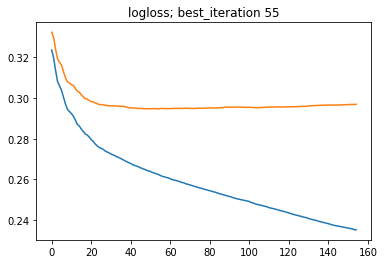

In [22]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

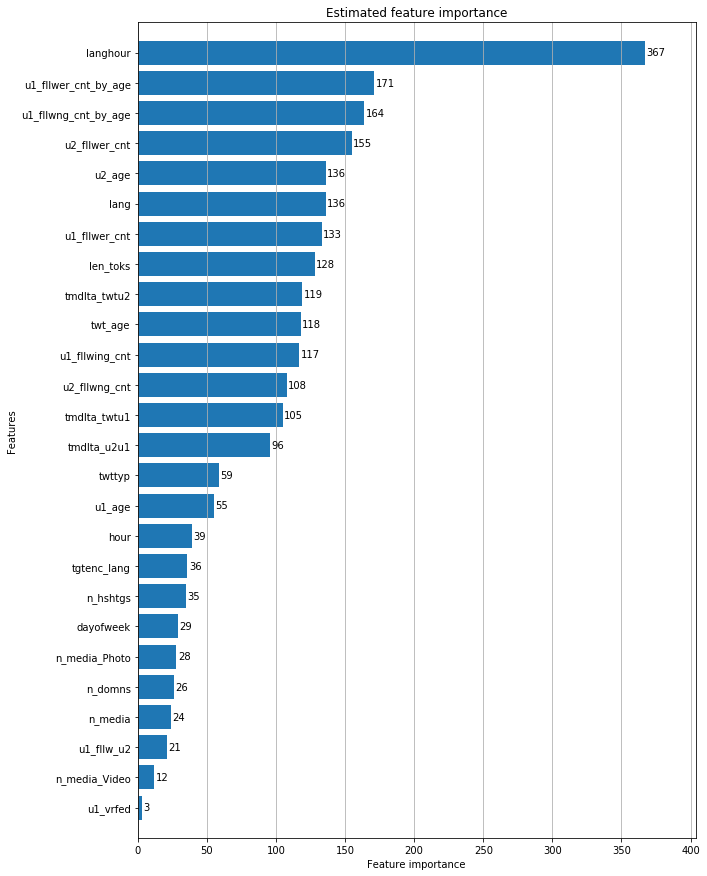

In [23]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [24]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
26,langhour,367
24,u1_fllwer_cnt_by_age,171
25,u1_fllwng_cnt_by_age,164
5,u2_fllwer_cnt,155
23,u2_age,136
1,lang,136
2,u1_fllwer_cnt,133
9,len_toks,128
20,tmdlta_twtu2,119
21,twt_age,118


# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 3.12 s, sys: 3.67 s, total: 6.79 s
Wall time: 705 ms


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 930 ms, sys: 1.75 s, total: 2.68 s
Wall time: 664 ms


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4209
auc_vl:  0.2932
auc_val: 0.0940

rce_tr:  21.5492
rce_vl:  13.7968
rce_val: 10.2780


In [28]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0940-10.2780


# save results

In [29]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [30]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [31]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 35.5 ms, sys: 98.5 ms, total: 134 ms
Wall time: 8.76 ms


In [32]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-06 13:08:11 start
2020-04-06 13:08:11 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 13:08:11 freq of tags
2020-04-06 13:08:11 done
CPU times: user 335 ms, sys: 1.15 s, total: 1.48 s
Wall time: 162 ms


In [33]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [34]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 30.6 ms, sys: 68.4 ms, total: 99 ms
Wall time: 25.7 ms


In [35]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)